# setup


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import cmcrameri.cm
import pymannkendall as mk
import statsmodels.api as sm
#import line2d
from matplotlib.lines import Line2D
from scipy.stats import entropy


In [12]:
ibge = gpd.read_file(r'Data\IBGE\BiomasBrasil.shp')
shp_cerrado = ibge[ibge.biomas == 'CERRADO']
ds_knn = xr.open_dataset(r'Data\knn_cerrado3.nc')
ds_knn.rio.write_crs(shp_cerrado.crs, inplace=True)
regions = gpd.read_file(r'Data\regions1.geojson')
gdf_knn = gpd.read_file('Data\gdf_knn_bet.geojson')
palette = sns.color_palette('cmc.batlow', 3)

In [13]:
gdf = gpd.read_file('Data\stations.geojson').to_crs(ibge.crs)
df_cerrado = pd.read_pickle(r'Data\df_cerrado_bet.pkl')
gdf_filtered = gdf[gdf.Code.isin(df_cerrado.Code.unique())]

In [14]:
gdf_knn = gpd.read_file('Data\gdf_knn_bet.geojson')
df_cerrado_regions = df_cerrado.merge(gdf_knn, on='Code', how='left')
hue_order = ['Central', 'Southern','Eastern']

# mk


## yearly


### stations


In [15]:
gdf_filtered_mk = gdf_knn.drop(columns=['map', 'dsl', 'dsl_std', 'dsl_cv', 'dry_precip', 'dry_precip_std',
       'dry_precip_cv', 'wet_precip', 'wet_precip_std', 'wet_precip_cv', 'msi',
       'Entropy', 'cluster_kmeans', 'knn']).copy()

df_stat_year = df_cerrado_regions.groupby(['Code',df_cerrado_regions.Date.dt.year]).sum().reset_index()       

C:\Users\luisg\AppData\Local\Temp\ipykernel_21224\2619567733.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_stat_year = df_cerrado_regions.groupby(['Code',df_cerrado_regions.Date.dt.year]).sum().reset_index()


In [16]:
# do a mk test for each Code
for code in df_stat_year.Code.unique():
    test = mk.original_test(df_stat_year[df_stat_year.Code == code]['Total'])
    gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'trend'+ '_' + 'anual'] = test.trend
    gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'p'+ '_' + 'anual'] = test.p
    gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'slope'+ '_' + 'anual'] = test.slope
    gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'intercept'+ '_' + 'anual'] = test.intercept
#gdf_filtered_mk[gdf_filtered_mk.Code == 1749005]


## seasonal


### all


In [17]:
#groupby season of year SON, DJF, MAM, JJA 
df_cerrado_regions['season'] = df_cerrado_regions.Date.dt.month.apply(lambda x: 'DJF' if x in [12, 1, 2] else ('MAM' if x in [3, 4, 5] else ('JJA' if x in [6, 7, 8] else 'SON')))
df_cerrado_regions


,Code,Date,Total,Name,Latitude,Longitude,Altitude,map,dsl,dsl_std,...,wet_precip,wet_precip_std,wet_precip_cv,msi,Entropy,cluster_kmeans,knn,region,geometry,season
0,343001,1981-01-01,130.900000,IGUARÁ,-3.5536,-43.8736,158.0,1648.37206,6.566667,1.006302,...,1465.585086,440.163045,0.300333,0.628205,0.634846,0,0,Central,POINT (-43.87360 -3.55360),DJF
1,343001,1982-01-01,321.000000,IGUARÁ,-3.5536,-43.8736,158.0,1648.37206,6.566667,1.006302,...,1465.585086,440.163045,0.300333,0.628205,0.634846,0,0,Central,POINT (-43.87360 -3.55360),DJF
2,343001,1983-01-01,110.600000,IGUARÁ,-3.5536,-43.8736,158.0,1648.37206,6.566667,1.006302,...,1465.585086,440.163045,0.300333,0.628205,0.634846,0,0,Central,POINT (-43.87360 -3.55360),DJF
3,343001,1984-01-01,357.200000,IGUARÁ,-3.5536,-43.8736,158.0,1648.37206,6.566667,1.006302,...,1465.585086,440.163045,0.300333,0.628205,0.634846,0,0,Central,POINT (-43.87360 -3.55360),DJF
4,343001,1985-01-01,332.800000,IGUARÁ,-3.5536,-43.8736,158.0,1648.37206,6.566667,1.006302,...,1465.585086,440.163045,0.300333,0.628205,0.634846,0,0,Central,POINT (-43.87360 -3.55360),DJF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172075,2450036,2006-12-01,169.500000,FAZENDA REDOMONA,-24.2586,-50.0839,957.0,1616.75608,5.500000,1.696853,...,1295.689301,393.183300,0.303455,0.257009,0.094474,1,1,Southern,POINT (-50.08390 -24.25860),DJF
172076,2450036,2007-12-01,319.900000,FAZENDA REDOMONA,-24.2586,-50.0839,957.0,1616.75608,5.500000,1.696853,...,1295.689301,393.183300,0.303455,0.257009,0.094474,1,1,Southern,POINT (-50.08390 -24.25860),DJF
172077,2450036,2008-12-01,168.700000,FAZENDA REDOMONA,-24.2586,-50.0839,957.0,1616.75608,5.500000,1.696853,...,1295.689301,393.183300,0.303455,0.257009,0.094474,1,1,Southern,POINT (-50.08390 -24.25860),DJF
172078,2450036,2009-12-01,151.036479,FAZENDA REDOMONA,-24.2586,-50.0839,957.0,1616.75608,5.500000,1.696853,...,1295.689301,393.183300,0.303455,0.257009,0.094474,1,1,Southern,POINT (-50.08390 -24.25860),DJF


### stations


In [18]:
df_stat_season= df_cerrado.groupby(['Code',df_cerrado.Date.dt.year, 'season']).mean().reset_index() 

KeyError: 'season'

In [ ]:
# do a mk test for each season and each code
for season in df_stat_season.season.unique():
    for code in df_stat_season.Code.unique():
        test = mk.original_test(df_stat_season[(df_stat_season.season == season) & (df_stat_season.Code == code)]['Total'])
        #create a column for each season
        gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'trend'+ '_' + season] = test.trend
        gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'p'+ '_' + season] = test.p
        gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'slope'+'_' +  season] = test.slope
        gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'intercept'+ '_' + season] = test.intercept

# DF bar plot


In [ ]:
# create df with percentages of each trend by season

dff = (100 * gdf_filtered_mk.groupby('region').trend_anual.value_counts() / gdf_filtered_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_filtered_mk.trend_anual.value_counts() / gdf_filtered_mk.shape[0]).reset_index()
# concat dff and dff_all
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_anual = pd.concat([dff, dff_all])
df_anual['Period'] = 'Anual'

# save as the cell above but for each season
dff = (100 * gdf_filtered_mk.groupby('region').trend_DJF.value_counts() / gdf_filtered_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_filtered_mk.trend_DJF.value_counts() / gdf_filtered_mk.shape[0]).reset_index()
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_DJF = pd.concat([dff, dff_all])
df_DJF['Period'] = 'DJF'

dff = (100 * gdf_filtered_mk.groupby('region').trend_MAM.value_counts() / gdf_filtered_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_filtered_mk.trend_MAM.value_counts() / gdf_filtered_mk.shape[0]).reset_index()
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_MAM = pd.concat([dff, dff_all])
df_MAM['Period'] = 'MAM'

dff = (100 * gdf_filtered_mk.groupby('region').trend_JJA.value_counts() / gdf_filtered_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_filtered_mk.trend_JJA.value_counts() / gdf_filtered_mk.shape[0]).reset_index()
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_JJA = pd.concat([dff, dff_all])
df_JJA['Period'] = 'JJA'

dff = (100 * gdf_filtered_mk.groupby('region').trend_SON.value_counts() / gdf_filtered_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_filtered_mk.trend_SON.value_counts() / gdf_filtered_mk.shape[0]).reset_index()
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_SON = pd.concat([dff, dff_all])
df_SON['Period'] = 'SON'
#concat all seasons

df_trends = pd.concat([df_anual, df_DJF, df_MAM, df_JJA, df_SON]).reset_index(drop=True)


In [ ]:
#create rows for each regioN with Periodo JJA, Trend=increasing and Percentage=0
df_trends = df_trends.append({'region': 'Central', 'Period': 'JJA', 'Trend': 'increasing', 'Percentage': 0}, ignore_index=True)
df_trends = df_trends.append({'region': 'Southern', 'Period': 'JJA', 'Trend': 'increasing', 'Percentage': 0}, ignore_index=True)
df_trends = df_trends.append({'region': 'Eastern', 'Period': 'JJA', 'Trend': 'increasing', 'Percentage': 0}, ignore_index=True)
df_trends = df_trends.append({'region': 'All', 'Period': 'JJA', 'Trend': 'increasing', 'Percentage': 0}, ignore_index=True)


C:\Users\luisg\AppData\Local\Temp\ipykernel_26700\3356703512.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_trends = df_trends.append({'region': 'Central', 'Period': 'JJA', 'Trend': 'increasing', 'Percentage': 0}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_26700\3356703512.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_trends = df_trends.append({'region': 'Southern', 'Period': 'JJA', 'Trend': 'increasing', 'Percentage': 0}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_26700\3356703512.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_trends = df_trends.append({'region': 'Eastern', 'Period': 'JJA', 'Trend': 'increasing', 'Percentage': 0}, ignore_index=True)
C:\Users\

## slopes


In [ ]:
#count by region and season how many codes have a negative slope
dff = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_anual < 0].groupby('region').size() / gdf_filtered_mk.groupby('region').size()).reset_index().rename(columns={0:'Negative slope'})
dff_all = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_anual < 0].shape[0] / gdf_filtered_mk.shape[0])#.reset_index().rename(columns={0:'Negative slope'})
dff_all = pd.DataFrame({'region': ['All'], 'Negative slope': [dff_all]})
dff = pd.concat([dff, dff_all])
dff['Positive slope'] = 100 - dff['Negative slope']
dff_anual = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
dff_anual['Period'] = 'Anual'

#now for each season
dff = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_DJF < 0].groupby('region').size() / gdf_filtered_mk.groupby('region').size()).reset_index().rename(columns={0:'Negative slope'})
dff_all = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_DJF < 0].shape[0] / gdf_filtered_mk.shape[0])#.reset_index().rename(columns={0:'Negative slope'})
dff_all = pd.DataFrame({'region': ['All'], 'Negative slope': [dff_all]})
dff = pd.concat([dff, dff_all])
dff['Positive slope'] = 100 - dff['Negative slope']
dff_DJF = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
dff_DJF['Period'] = 'DJF'

dff = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_MAM < 0].groupby('region').size() / gdf_filtered_mk.groupby('region').size()).reset_index().rename(columns={0:'Negative slope'})
dff_all = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_MAM < 0].shape[0] / gdf_filtered_mk.shape[0])#.reset_index().rename(columns={0:'Negative slope'})
dff_all = pd.DataFrame({'region': ['All'], 'Negative slope': [dff_all]})
dff = pd.concat([dff, dff_all])
dff['Positive slope'] = 100 - dff['Negative slope']
dff_MAM = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
dff_MAM['Period'] = 'MAM'

dff = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_JJA < 0].groupby('region').size() / gdf_filtered_mk.groupby('region').size()).reset_index().rename(columns={0:'Negative slope'})
dff_all = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_JJA < 0].shape[0] / gdf_filtered_mk.shape[0])#.reset_index().rename(columns={0:'Negative slope'})
dff_all = pd.DataFrame({'region': ['All'], 'Negative slope': [dff_all]})
dff = pd.concat([dff, dff_all])
dff['Positive slope'] = 100 - dff['Negative slope']
dff_JJA = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
dff_JJA['Period'] = 'JJA'

dff = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_SON < 0].groupby('region').size() / gdf_filtered_mk.groupby('region').size()).reset_index().rename(columns={0:'Negative slope'})
dff_all = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_SON < 0].shape[0] / gdf_filtered_mk.shape[0])#.reset_index().rename(columns={0:'Negative slope'})
dff_all = pd.DataFrame({'region': ['All'], 'Negative slope': [dff_all]})
dff = pd.concat([dff, dff_all])
dff['Positive slope'] = 100 - dff['Negative slope']
dff_SON = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
dff_SON['Period'] = 'SON'

#concat all seasons
df_slopes = pd.concat([dff_anual, dff_DJF, dff_MAM, dff_JJA, dff_SON]).reset_index(drop=True)


In [ ]:
dff = (100 * gdf_filtered_mk.groupby('region').trend_anual.value_counts() / gdf_filtered_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_filtered_mk.trend_anual.value_counts() / gdf_filtered_mk.shape[0]).reset_index()
# concat dff and dff_all
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_anual = pd.concat([dff, dff_all])
df_anual['Period'] = 'Anual'

# PLOT


In [ ]:
#import Line2D
from matplotlib.lines import Line2D

In [ ]:
#EXCLUDE DATA with no trend
df_trends = df_trends[df_trends.Trend != 'no trend']

In [ ]:
df_trends.to_csv(r'Data\tendency\df_trends_pr.csv')
df_slopes.to_csv(r'Data\tendency\df_slopes_pr.csv')
gdf_filtered_mk.to_file(r'Data\tendency\gdf_mk_pr.geojson', driver='GeoJSON')

# Entropy


In [ ]:
df_cerrado_ent = df_cerrado_regions.sort_values(by=['Code', 'Date']).reset_index(drop=True)
df_cerrado_ent.groupby(['Code', df_cerrado_ent.Date.dt.year]).mean(numeric_only=True)
df_cerrado_ent['ratio'] = df_cerrado_ent.groupby(['Code', df_cerrado_ent.Date.dt.year])['Total'].apply(lambda x: x/x.sum()).rename('ratio').reset_index()['ratio']
uniform = np.zeros(12)
uniform[:] = 1/12
df_cerrado_ent_all = df_cerrado_ent.groupby(['Code', df_cerrado_ent.Date.dt.year])['ratio'].apply(lambda x: entropy(x, qk=uniform,base=2)).reset_index().rename({'ratio': 'Entropy'},  axis='columns')

C:\Users\luisg\AppData\Local\Temp\ipykernel_26700\578818975.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_cerrado_ent['ratio'] = df_cerrado_ent.groupby(['Code', df_cerrado_ent.Date.dt.year])['Total'].apply(lambda x: x/x.sum()).rename('ratio').reset_index()['ratio']


In [ ]:
#merge df_cerrado_ent_all with
df_cerrado_ent_all = df_cerrado_ent_all.merge(gdf_knn[['Code' ,'region']], on='Code', how='left')

## stations


In [ ]:
for code in df_cerrado_ent_all.Code.unique():
    test = mk.original_test(df_cerrado_ent_all[df_cerrado_ent_all.Code == code]['Entropy'])
    gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'trend'+ '_' + 'ent'] = test.trend
    gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'p'+ '_' + 'ent'] = test.p
    gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'slope'+ '_' + 'ent'] = test.slope
    gdf_filtered_mk.loc[gdf_filtered_mk.Code == code, 'intercept'+ '_' + 'ent'] = test.intercept

In [ ]:
dff = (100 * gdf_filtered_mk.groupby('region').trend_ent.value_counts() / gdf_filtered_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_filtered_mk.trend_ent.value_counts() / gdf_filtered_mk.shape[0]).reset_index()
# concat dff and dff_all
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_ent_trend = pd.concat([dff, dff_all])


In [ ]:
dff = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_ent < 0].groupby('region').size() / gdf_filtered_mk.groupby('region').size()).reset_index().rename(columns={0:'Negative slope'})
dff_all = (100 * gdf_filtered_mk[gdf_filtered_mk.slope_ent < 0].shape[0] / gdf_filtered_mk.shape[0])#.reset_index().rename(columns={0:'Negative slope'})
dff_all = pd.DataFrame({'region': ['All'], 'Negative slope': [dff_all]})
dff = pd.concat([dff, dff_all])
dff['Positive slope'] = 100 - dff['Negative slope']
dff_ent_slope = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')


In [ ]:
df_ent_trend = df_ent_trend[df_ent_trend.Trend != 'no trend']

In [ ]:
#import TwoSlopeNorm
from matplotlib.colors import TwoSlopeNorm

In [ ]:
#df_ent_trend.to_csv(r'Data\tendency\df_trends_ent.csv')
#dff_ent_slope.to_csv(r'Data\tendency\df_slopes_ent.csv')
gdf_filtered_mk.to_file(r'Data\tendency\gdf_mk_pr_ent.geojson', driver='GeoJSON')

# KDES


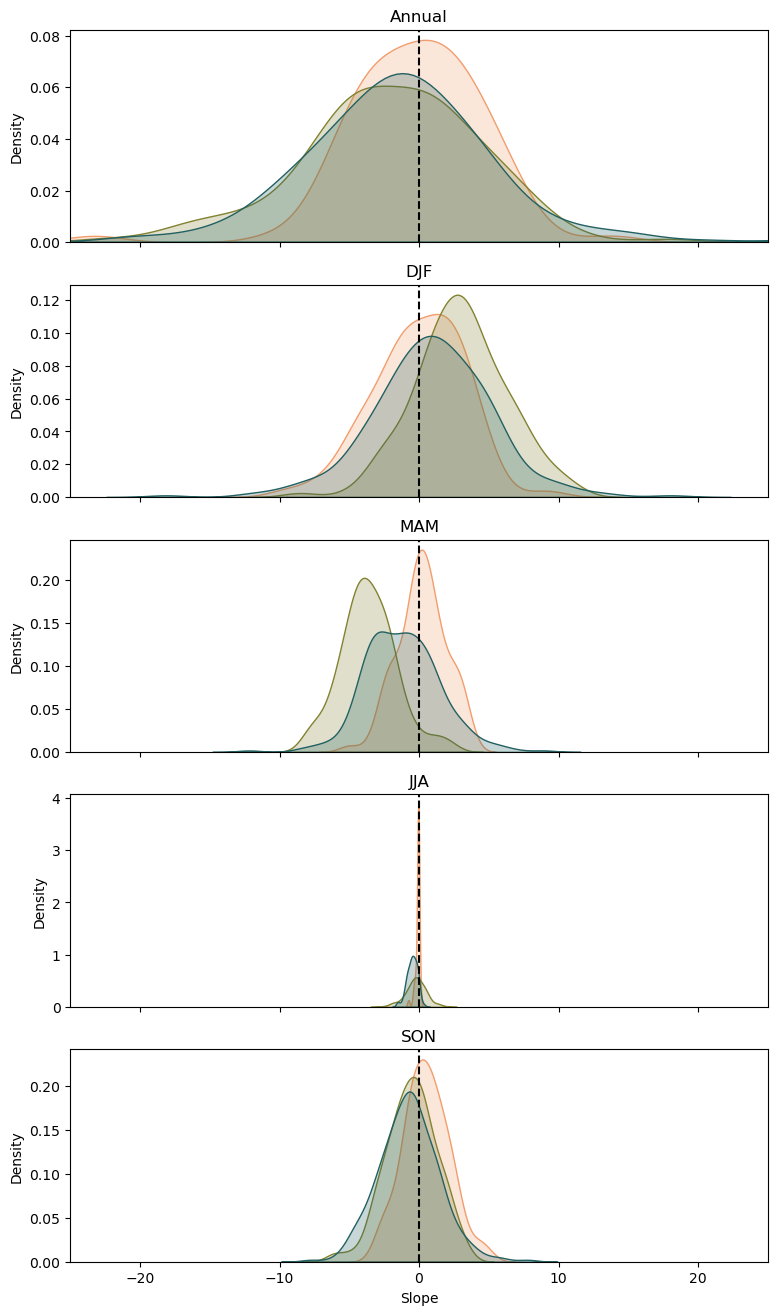

In [ ]:
#subplot of kde for all slopes columns
fig , ax = plt.subplots(5,1, figsize=(9, 16), sharex=True)

sns.kdeplot(gdf_filtered_mk, legend=False, hue= 'region', x='slope_anual', fill=True, palette=palette, hue_order=hue_order, ax=ax[0], common_norm=False)
sns.kdeplot(gdf_filtered_mk, legend=False, hue= 'region', x='slope_DJF', fill=True, palette=palette, hue_order=hue_order, ax=ax[1],common_norm=False)
sns.kdeplot(gdf_filtered_mk, legend=False, hue= 'region', x='slope_MAM', fill=True, palette=palette, hue_order=hue_order, ax=ax[2],common_norm=False)
sns.kdeplot(gdf_filtered_mk, legend=False, hue= 'region', x='slope_JJA', fill=True, palette=palette, hue_order=hue_order, ax=ax[3],common_norm=False)
sns.kdeplot(gdf_filtered_mk, legend=False, hue= 'region', x='slope_SON', fill=True, palette=palette, hue_order=hue_order, ax=ax[4],common_norm=False)

ax[0].set_title('Annual')
ax[1].set_title('DJF')
ax[2].set_title('MAM')
ax[3].set_title('JJA')
ax[4].set_title('SON')
ax[4].set_xlabel('Slope')
ax[4].set_xlim([-25, 25])
#plot a vertical line in 0
for i in range(5):
    ax[i].axvline(x=0, color='black', linestyle='--')
    ax[i].set_ylabel('Density')


# VPD


In [25]:
#open r'Data\Inmet\df_INMET_monthly.csv'
df_inmet = pd.read_csv(r'Data\Inmet\df_INMET_monthly.csv')
df_inmet_stat = pd.read_csv('Data\inmet_stat_cerrado.csv', index_col=0)
gdf_inmet = gpd.GeoDataFrame(df_inmet_stat, geometry=gpd.points_from_xy(df_inmet_stat.Longitude, df_inmet_stat.Latitude))
gdf_inmet = gdf_inmet.set_crs(epsg=4326).to_crs(regions.crs)
gdf_inmet = gpd.sjoin(gdf_inmet, regions, how='left', op='within')
#merge with df_inmet
df_inmet = df_inmet.merge(gdf_inmet[['Code', 'region']], on='Code', how='left')
df_inmet['Date'] = pd.to_datetime(df_inmet['Date'], format='%Y-%m-%d')


FileNotFoundError: [Errno 2] No such file or directory: 'Data\\inmet_stat_cerrado.csv'

## year


C:\Users\luisg\AppData\Local\Temp\ipykernel_26700\2439234788.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_inmet_all = df_inmet.groupby([df_inmet.Date.dt.year, 'Hour']).mean().reset_index().drop(columns='Code')


array([[<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
        <AxesSubplot: xlabel='Date'>],
       [<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
        <AxesSubplot: xlabel='Date'>],
       [<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
        <AxesSubplot: xlabel='Date'>]], dtype=object)

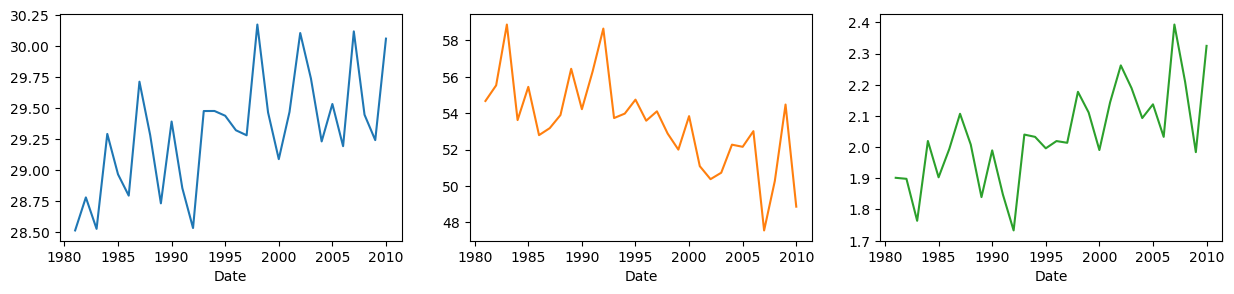

In [ ]:
#for Hour 0 and 12 plot each variable time series

df_inmet_all = df_inmet.groupby([df_inmet.Date.dt.year, 'Hour']).mean().reset_index().drop(columns='Code')
df_inmet_hour = df_inmet_all[df_inmet_all.Hour == 18]
df_inmet_hour = df_inmet_hour.drop(columns='Hour')
df_inmet_hour = df_inmet_hour.set_index('Date')
df_inmet_hour.plot(subplots=True, figsize=(15, 10), layout=(3, 3), legend=False)


### stations


In [ ]:
df_vpd_stat_year = df_inmet.groupby(['Code',df_inmet.Date.dt.year]).mean().reset_index()
gdf_inmet_mk = gdf_inmet[gdf_inmet.Code.isin(df_vpd_stat_year.Code.unique())][['Code', 'region', 'geometry']].copy()       

C:\Users\luisg\AppData\Local\Temp\ipykernel_20664\2238050952.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_vpd_stat_year = df_inmet.groupby(['Code',df_inmet.Date.dt.year]).mean().reset_index()


In [ ]:
# do a mk test for each Code
for code in df_vpd_stat_year.Code.unique():
    test = mk.original_test(df_vpd_stat_year[df_vpd_stat_year.Code == code]['VPD'])
    gdf_inmet_mk.loc[gdf_inmet_mk.Code == code, 'trend'+ '_' + 'anual'] = test.trend
    gdf_inmet_mk.loc[gdf_inmet_mk.Code == code, 'p'+ '_' + 'anual'] = test.p
    gdf_inmet_mk.loc[gdf_inmet_mk.Code == code, 'slope'+ '_' + 'anual'] = test.slope
    gdf_inmet_mk.loc[gdf_inmet_mk.Code == code, 'intercept'+ '_' + 'anual'] = test.intercept


In [ ]:
cmap = 'RdBu_r'


<AxesSubplot: >

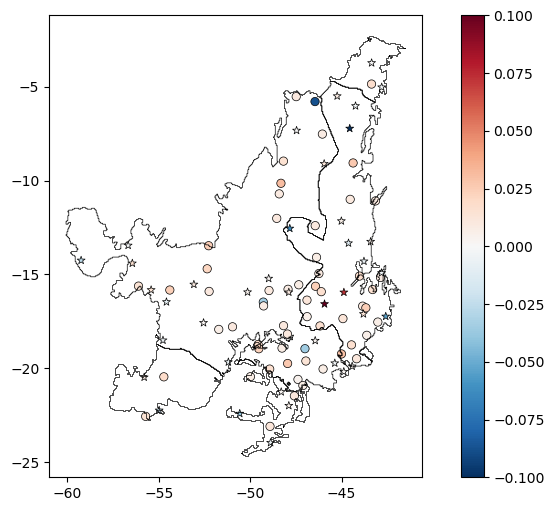

In [ ]:
from matplotlib.colors import TwoSlopeNorm
fig , ax = plt.subplots(figsize=(10, 6))
from matplotlib.colors import TwoSlopeNorm

norm = TwoSlopeNorm(vmin=-0.1, vcenter=0, vmax=0.1)

gdf_inmet_mk[gdf_inmet_mk.p_anual <= 0.05].plot(column='slope_anual', ax=ax, cmap=cmap,
 edgecolor='black', linewidth=0.5, marker='o', legend=True, norm=norm)

gdf_inmet_mk[gdf_inmet_mk.p_anual > 0.05].plot(column='slope_anual', ax=ax, cmap=cmap,
 edgecolor='black', linewidth=0.5, marker='*',norm=norm)

#shp_cerrado.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
#plot regions
regions.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

In [ ]:
dff = (100 * gdf_inmet_mk.groupby('region').trend_anual.value_counts() / gdf_inmet_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_inmet_mk.trend_anual.value_counts() / gdf_inmet_mk.shape[0]).reset_index()
# concat dff and dff_all
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_anual = pd.concat([dff, dff_all])
df_anual['Period'] = 'Anual'


## seasonal


### stations


In [ ]:
df_inmet_stat_season = df_inmet.groupby(['Code',df_inmet.Date.dt.year, 'season']).mean().reset_index() 

C:\Users\luisg\AppData\Local\Temp\ipykernel_20664\933235691.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_inmet_stat_season = df_inmet.groupby(['Code',df_inmet.Date.dt.year, 'season']).mean().reset_index()


In [ ]:
# do a mk test for each season and each code
for season in df_inmet_stat_season.season.unique():
    for code in df_inmet_stat_season.Code.unique():
        test = mk.original_test(df_inmet_stat_season[(df_inmet_stat_season.season == season) & (df_inmet_stat_season.Code == code)]['VPD'])
        #create a column for each season
        gdf_inmet_mk.loc[gdf_inmet_mk.Code == code, 'trend'+ '_' + season] = test.trend
        gdf_inmet_mk.loc[gdf_inmet_mk.Code == code, 'p'+ '_' + season] = test.p
        gdf_inmet_mk.loc[gdf_inmet_mk.Code == code, 'slope'+'_' +  season] = test.slope
        gdf_inmet_mk.loc[gdf_inmet_mk.Code == code, 'intercept'+'_' +  season] = test.intercept

In [ ]:
#values cont for each column trend_season
gdf_inmet_mk.trend_DJF.value_counts()
gdf_inmet_mk.trend_MAM.value_counts()
gdf_inmet_mk.trend_JJA.value_counts()
gdf_inmet_mk.trend_SON.value_counts()

no trend      52
increasing    45
decreasing     1
Name: trend_SON, dtype: int64

### df plots


In [ ]:
dff = (100 * gdf_inmet_mk.groupby('region').trend_anual.value_counts() / gdf_inmet_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_inmet_mk.trend_anual.value_counts() / gdf_inmet_mk.shape[0]).reset_index()
# concat dff and dff_all
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_anual = pd.concat([dff, dff_all])
df_anual['Period'] = 'Anual'

# save as the cell above but for each season
dff = (100 * gdf_inmet_mk.groupby('region').trend_DJF.value_counts() / gdf_inmet_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_inmet_mk.trend_DJF.value_counts() / gdf_inmet_mk.shape[0]).reset_index()
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_DJF = pd.concat([dff, dff_all])
df_DJF['Period'] = 'DJF'

dff = (100 * gdf_inmet_mk.groupby('region').trend_MAM.value_counts() / gdf_inmet_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_inmet_mk.trend_MAM.value_counts() / gdf_inmet_mk.shape[0]).reset_index()
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_MAM = pd.concat([dff, dff_all])
df_MAM['Period'] = 'MAM'

dff = (100 * gdf_inmet_mk.groupby('region').trend_JJA.value_counts() / gdf_inmet_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_inmet_mk.trend_JJA.value_counts() / gdf_inmet_mk.shape[0]).reset_index()
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_JJA = pd.concat([dff, dff_all])
df_JJA['Period'] = 'JJA'

dff = (100 * gdf_inmet_mk.groupby('region').trend_SON.value_counts() / gdf_inmet_mk.groupby('region').size()).unstack().reset_index()
dff_all = (100 * gdf_inmet_mk.trend_SON.value_counts() / gdf_inmet_mk.shape[0]).reset_index()
dff_all['region'] = 'All'
dff_all.columns = ['Trend', 'Percentage', 'region']
dff_all = dff_all[['region', 'Trend', 'Percentage']]
dff = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
df_SON = pd.concat([dff, dff_all])
df_SON['Period'] = 'SON'
#concat all seasons

df_trends_vpd = pd.concat([df_anual, df_DJF, df_MAM, df_JJA, df_SON]).reset_index(drop=True)


In [ ]:
#count by region and season how many codes have a negative slope
dff = (100 * gdf_inmet_mk[gdf_inmet_mk.slope_anual < 0].groupby('region').size() / gdf_inmet_mk.groupby('region').size()).reset_index().rename(columns={0:'Negative slope'})
dff_all = (100 * gdf_inmet_mk[gdf_inmet_mk.slope_anual < 0].shape[0] / gdf_inmet_mk.shape[0])#.reset_index().rename(columns={0:'Negative slope'})
dff_all = pd.DataFrame({'region': ['All'], 'Negative slope': [dff_all]})
dff = pd.concat([dff, dff_all])
dff['Positive slope'] = 100 - dff['Negative slope']
dff_anual = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
dff_anual['Period'] = 'Anual'

#now for each season
dff = (100 * gdf_inmet_mk[gdf_inmet_mk.slope_DJF < 0].groupby('region').size() / gdf_inmet_mk.groupby('region').size()).reset_index().rename(columns={0:'Negative slope'})
dff_all = (100 * gdf_inmet_mk[gdf_inmet_mk.slope_DJF < 0].shape[0] / gdf_inmet_mk.shape[0])#.reset_index().rename(columns={0:'Negative slope'})
dff_all = pd.DataFrame({'region': ['All'], 'Negative slope': [dff_all]})
dff = pd.concat([dff, dff_all])
dff['Positive slope'] = 100 - dff['Negative slope']
dff_DJF = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
dff_DJF['Period'] = 'DJF'

dff = (100 * gdf_inmet_mk[gdf_inmet_mk.slope_MAM < 0].groupby('region').size() / gdf_inmet_mk.groupby('region').size()).reset_index().rename(columns={0:'Negative slope'})
dff_all = (100 * gdf_inmet_mk[gdf_inmet_mk.slope_MAM < 0].shape[0] / gdf_inmet_mk.shape[0])#.reset_index().rename(columns={0:'Negative slope'})
dff_all = pd.DataFrame({'region': ['All'], 'Negative slope': [dff_all]})
dff = pd.concat([dff, dff_all])
dff['Positive slope'] = 100 - dff['Negative slope']
dff_MAM = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
dff_MAM['Period'] = 'MAM'

dff = (100 * gdf_inmet_mk[gdf_inmet_mk.slope_JJA < 0].groupby('region').size() / gdf_inmet_mk.groupby('region').size()).reset_index().rename(columns={0:'Negative slope'})
dff_all = (100 * gdf_inmet_mk[gdf_inmet_mk.slope_JJA < 0].shape[0] / gdf_inmet_mk.shape[0])#.reset_index().rename(columns={0:'Negative slope'})
dff_all = pd.DataFrame({'region': ['All'], 'Negative slope': [dff_all]})
dff = pd.concat([dff, dff_all])
dff['Positive slope'] = 100 - dff['Negative slope']
dff_JJA = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
dff_JJA['Period'] = 'JJA'

dff = (100 * gdf_inmet_mk[gdf_inmet_mk.slope_SON < 0].groupby('region').size() / gdf_inmet_mk.groupby('region').size()).reset_index().rename(columns={0:'Negative slope'})
dff_all = (100 * gdf_inmet_mk[gdf_inmet_mk.slope_SON < 0].shape[0] / gdf_inmet_mk.shape[0])#.reset_index().rename(columns={0:'Negative slope'})
dff_all = pd.DataFrame({'region': ['All'], 'Negative slope': [dff_all]})
dff = pd.concat([dff, dff_all])
dff['Positive slope'] = 100 - dff['Negative slope']
dff_SON = dff.melt(id_vars=['region'],  var_name=['Trend'], value_name='Percentage')
dff_SON['Period'] = 'SON'

#concat all seasons
df_slopes_vpd = pd.concat([dff_anual, dff_DJF, dff_MAM, dff_JJA, dff_SON]).reset_index(drop=True)


In [ ]:
#df_trends_vpd.to_csv(r'Data\tendency\df_trends_vpd.csv')
#df_slopes_vpd.to_csv(r'Data\tendency\df_slopes_vpd.csv')
gdf_inmet_mk.to_file(r'Data\tendency\gdf_mk_vpd.geojson', driver='GeoJSON')

## all variables


In [ ]:
gdf_mk_vpd = gpd.read_file(r'Data\tendency\gdf_mk_vpd.geojson')


In [ ]:
#year
df_vpd_stat_year = df_inmet.groupby(['Code',df_inmet.Date.dt.year]).mean().reset_index()


for var in ['Temp_min', 'RH_min', 'Temp_max', 'RH_max']:
    for code in df_vpd_stat_year.Code.unique():
        test = mk.original_test(df_vpd_stat_year[df_vpd_stat_year.Code == code][var])
        #gdf_mk_vpd.loc[gdf_mk_vpd.Code == code, 'trend'+ '_' + 'anual'] = test.trend
        gdf_mk_vpd.loc[gdf_mk_vpd.Code == code, 'p' + '_' + var+ '_'+ 'anual'] = test.p
        gdf_mk_vpd.loc[gdf_mk_vpd.Code == code, 'slope' + '_' + var + '_'+ 'anual'] = test.slope
        gdf_mk_vpd.loc[gdf_mk_vpd.Code == code, 'intercept' + '_' + var+ '_'+ 'anual'] = test.intercept        

NameError: name 'df_inmet' is not defined

In [ ]:
df_inmet['season'] = df_inmet.Date.dt.month.apply(lambda x: 'DJF' if x in [12, 1, 2] else ('MAM' if x in [3, 4, 5] else ('JJA' if x in [6, 7, 8] else 'SON')))
df_inmet_stat_season = df_inmet.groupby(['Code',df_inmet.Date.dt.year, 'season']).mean().reset_index() 

C:\Users\luisg\AppData\Local\Temp\ipykernel_5656\3557515208.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_inmet_stat_season = df_inmet.groupby(['Code',df_inmet.Date.dt.year, 'season']).mean().reset_index()


In [ ]:
# do a mk test for each season and each code
for season in df_inmet_stat_season.season.unique():
    dff = df_inmet_stat_season[df_inmet_stat_season.season == season].copy()
    for var in ['Temp_min', 'RH_min', 'Temp_max', 'RH_max']:
        for code in dff.Code.unique():
            test = mk.original_test(dff[dff.Code == code][var])
            #gdf_mk_vpd.loc[gdf_mk_vpd.Code == code, 'trend'+ '_' + season] = test.trend
            gdf_mk_vpd.loc[gdf_mk_vpd.Code == code, 'p' + '_' + var+ '_'+ season] = test.p
            gdf_mk_vpd.loc[gdf_mk_vpd.Code == code, 'slope' + '_' + var + '_'+ season] = test.slope
            gdf_mk_vpd.loc[gdf_mk_vpd.Code == code, 'intercept' + '_' + var+ '_'+ season] = test.intercept    

# percentages


In [22]:
#open files of pr
df_slopes_pr = pd.read_csv(r'Data\tendency\df_slopes_pr.csv', index_col=0)
df_trends_pr = pd.read_csv(r'Data\tendency\df_trends_pr.csv', index_col=0)
gdf_mk_pr_ent = gpd.read_file(r'Data\tendency\gdf_mk_pr_ent.geojson')
#ent
df_slopes_ent = pd.read_csv(r'Data\tendency\df_slopes_ent.csv', index_col=0)
df_trends_ent = pd.read_csv(r'Data\tendency\df_trends_ent.csv', index_col=0)
#vpd
df_slopes_vpd = pd.read_csv(r'Data\tendency\df_slopes_vpd.csv', index_col=0)
df_trends_vpd = pd.read_csv(r'Data\tendency\df_trends_vpd.csv', index_col=0)

gdf_inmet_clim = gpd.read_file(r'Data\Inmet\gdf_inmet_clim.geojson')

In [26]:
df_inmet = pd.read_csv(r'Data\Inmet\df_INMET_monthly.csv')


## vpd


In [27]:
#get only rows with size bigger than 180
gdf_inmet_clim = gdf_inmet_clim[gdf_inmet_clim['size'] > 180].reset_index(drop=True)
#filter gdf_mk_vpd with codes
gdf_mk_vpd = gdf_mk_vpd[gdf_mk_vpd['Code'].isin(gdf_inmet_clim['Code'])].reset_index(drop=True)
#filter df_inmet
df_inmet = df_inmet[df_inmet['Code'].isin(gdf_inmet_clim['Code'])].reset_index(drop=True)

In [31]:
df_inmet['Date'] = pd.to_datetime(df_inmet['Date'], format='%Y-%m-%d')

In [32]:
#take the mean vpd for the first year for each code
df_inmet_first = df_inmet.groupby(['Code', df_inmet.Date.dt.year]).mean().reset_index().sort_values(['Code', 'Date']).groupby('Code').first().reset_index()
gdf_mk_vpd['VPD_ratio_anual'] = (gdf_mk_vpd['slope_anual'] / gdf_mk_vpd['intercept_anual'] * 100)
gdf_mk_vpd['VPD_anom_anual'] = (gdf_mk_vpd['slope_anual']*30)

C:\Users\luisg\AppData\Local\Temp\ipykernel_21224\791389391.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_inmet_first = df_inmet.groupby(['Code', df_inmet.Date.dt.year]).mean().reset_index().sort_values(['Code', 'Date']).groupby('Code').first().reset_index()


In [33]:
df_inmet['season'] = df_inmet.Date.dt.month.apply(lambda x: 'DJF' if x in [12, 1, 2] else ('MAM' if x in [3, 4, 5] else ('JJA' if x in [6, 7, 8] else 'SON')))
df_inmet_sea = df_inmet.groupby(['Code',df_inmet.Date.dt.year, 'season']).mean().reset_index()
df_inmet_sea_first = df_inmet_sea.drop_duplicates(subset=['Code', 'season'])
for sea in ['DJF' , 'MAM', 'JJA', 'SON']:
    df_season = df_inmet_sea_first[df_inmet_sea_first['season'] == sea].reset_index(drop=True)
    gdf_mk_vpd['VPD_ratio_' + sea] = (gdf_mk_vpd['slope_' + sea] / gdf_mk_vpd['intercept_' + sea] * 100)
    gdf_mk_vpd['VPD_anom_' + sea] = (gdf_mk_vpd['slope_' + sea]*30)

C:\Users\luisg\AppData\Local\Temp\ipykernel_21224\3559855787.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_inmet_sea = df_inmet.groupby(['Code',df_inmet.Date.dt.year, 'season']).mean().reset_index()


### RH TEMP

In [34]:
for var in ['Temp_min', 'RH_min', 'Temp_max', 'RH_max']:
    for sea in ['anual', 'DJF', 'MAM', 'JJA', 'SON']:
        gdf_mk_vpd['ratio_'+  var +'_' + sea] = (gdf_mk_vpd['slope_' +  var +'_' + sea] / gdf_mk_vpd['intercept_'+  var +'_' + sea] * 100)
        gdf_mk_vpd['anom_'+  var +'_' + sea] = (gdf_mk_vpd['slope_'+  var +'_' + sea]*30)


## pr


In [35]:
df_pr_first = df_cerrado.groupby(['Code',df_cerrado.Date.dt.year]).sum().reset_index().sort_values(['Code', 'Date']).groupby('Code').first().reset_index()  
gdf_mk_pr_ent['pr_ratio_anual'] = (gdf_mk_pr_ent['slope_anual'] / gdf_mk_pr_ent['intercept_anual'] * 100)
gdf_mk_pr_ent['pr_anom_anual'] = (gdf_mk_pr_ent['slope_anual']*30)

C:\Users\luisg\AppData\Local\Temp\ipykernel_21224\3259850999.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pr_first = df_cerrado.groupby(['Code',df_cerrado.Date.dt.year]).sum().reset_index().sort_values(['Code', 'Date']).groupby('Code').first().reset_index()


In [36]:
df_cerrado['season'] = df_cerrado.Date.dt.month.apply(lambda x: 'DJF' if x in [12, 1, 2] else ('MAM' if x in [3, 4, 5] else ('JJA' if x in [6, 7, 8] else 'SON')))
df_cerrado_sea = df_cerrado.groupby(['Code',df_cerrado.Date.dt.year, 'season']).mean().reset_index()
df_cerrado_sea_first = df_cerrado_sea.drop_duplicates(subset=['Code', 'season'])
for sea in ['DJF' , 'MAM', 'JJA', 'SON']:
    df_season = df_cerrado_sea_first[df_cerrado_sea_first['season'] == sea].reset_index(drop=True)
    gdf_mk_pr_ent['pr_ratio_' + sea] = (gdf_mk_pr_ent['slope_' + sea] / gdf_mk_pr_ent['intercept_' + sea] * 100)
    gdf_mk_pr_ent['pr_anom_' + sea] = (gdf_mk_pr_ent['slope_' + sea]*30)

C:\Users\luisg\AppData\Local\Temp\ipykernel_21224\2459628012.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cerrado_sea = df_cerrado.groupby(['Code',df_cerrado.Date.dt.year, 'season']).mean().reset_index()


## entropy


In [37]:
df_cerrado_ent = df_cerrado.sort_values(by=['Code', 'Date']).reset_index(drop=True)
df_cerrado_ent.groupby(['Code', df_cerrado_ent.Date.dt.year]).mean(numeric_only=True)
df_cerrado_ent['ratio'] = df_cerrado_ent.groupby(['Code', df_cerrado_ent.Date.dt.year])['Total'].apply(lambda x: x/x.sum()).rename('ratio').reset_index()['ratio']
uniform = np.zeros(12)
uniform[:] = 1/12
df_cerrado_ent_all = df_cerrado_ent.groupby(['Code', df_cerrado_ent.Date.dt.year])['ratio'].apply(lambda x: entropy(x, qk=uniform,base=2)).reset_index().rename({'ratio': 'Entropy'},  axis='columns')

C:\Users\luisg\AppData\Local\Temp\ipykernel_21224\2280703330.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_cerrado_ent['ratio'] = df_cerrado_ent.groupby(['Code', df_cerrado_ent.Date.dt.year])['Total'].apply(lambda x: x/x.sum()).rename('ratio').reset_index()['ratio']


In [38]:
df_ent_first = df_cerrado_ent_all.groupby('Code').first().reset_index()  
gdf_mk_pr_ent['ent_ratio'] = (gdf_mk_pr_ent['slope_ent'] / gdf_mk_pr_ent['intercept_ent'] * 100)
gdf_mk_pr_ent['ent_anom'] = (gdf_mk_pr_ent['slope_ent']*30)

## plots


In [39]:
from cmcrameri import cm
import cmasher as cmr
import matplotlib as mpl
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [40]:
gdf_mk_pr_ent.to_file(r'D:\GU\IC\Scripts\Data\tendency\gdf_mk_pr_ent.geojson', driver='GeoJSON')
gdf_mk_vpd.to_file(r'D:\GU\IC\Scripts\Data\tendency\gdf_mk_vpd.geojson', driver='GeoJSON')

In [41]:
gdf_mk_pr_ent

,Code,Name,Latitude,Longitude,Altitude,region,trend_DJF,p_DJF,slope_DJF,trend_JJA,...,pr_anom_DJF,pr_ratio_MAM,pr_anom_MAM,pr_ratio_JJA,pr_anom_JJA,pr_ratio_SON,pr_anom_SON,ent_ratio,ent_anom,geometry
0,343001,IGUARÁ,-3.5536,-43.8736,158.0,Central,no trend,0.775294,-0.648889,no trend,...,-19.466667,0.417750,34.357143,-0.201467,-1.729013,-0.749808,-3.633345,0.301373,0.067536,POINT (-43.87360 -3.55360)
1,343003,NINA RODRIGUES,-3.4594,-43.8989,112.0,Central,no trend,0.721226,-0.536667,no trend,...,-16.100000,0.561339,45.809524,0.472268,4.180632,-2.060078,-15.117137,0.498935,0.105087,POINT (-43.89890 -3.45940)
2,344004,CANTANHEDE,-3.6325,-44.3764,31.0,Central,no trend,0.802762,0.395238,no trend,...,11.857143,0.640978,53.222222,-1.415406,-15.646650,-1.006915,-8.566139,0.877524,0.170943,POINT (-44.37640 -3.63250)
3,344007,PERITORÓ II,-3.7097,-44.2933,145.0,Central,no trend,0.721226,0.522222,no trend,...,15.666667,0.380067,31.893527,-1.009091,-11.551418,-1.237614,-11.763052,0.890013,0.169976,POINT (-44.29330 -3.70970)
4,344008,PEDRAS,-3.9436,-44.0175,182.0,Central,no trend,0.401659,0.791964,no trend,...,23.758925,0.407646,35.142857,0.577165,3.638373,-1.123336,-7.063969,-0.121577,-0.031573,POINT (-44.01750 -3.94360)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,2449044,SENGES,-24.1000,-49.4667,650.0,Southern,no trend,0.568059,0.753333,no trend,...,22.600000,0.358680,9.285714,1.214158,18.415351,0.210585,6.692308,-0.207476,-0.023085,POINT (-49.46670 -24.10000)
474,2450002,TIBAJI,-24.5108,-50.4000,720.0,Southern,no trend,0.432450,-0.718771,no trend,...,-21.563138,-0.730269,-27.434770,-0.507372,-13.230913,0.785820,32.545455,0.020281,0.001635,POINT (-50.40000 -24.51080)
475,2450026,COLÔNIA IAPÓ,-24.6331,-50.1331,1050.0,Southern,no trend,0.914752,0.122222,no trend,...,3.666667,-0.587111,-21.235294,0.564677,13.821003,0.500182,20.636364,-0.408417,-0.033146,POINT (-50.13310 -24.63310)
476,2450031,GUARICANGA - PIRAI DO SUL,-24.3667,-50.1000,962.0,Southern,no trend,0.391793,0.984848,no trend,...,29.545455,-0.531316,-18.696792,0.242163,5.083698,0.416310,16.318182,-0.800425,-0.075739,POINT (-50.10000 -24.36670)
